### Курсовой проект

##### Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [95]:
# Подключаем библиотеки и модули

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

In [200]:
# Пути к исходным данным
TRAIN_DATASET_PATH = './input/bank_client_default_prediction/course_project_train.csv'
TEST_DATASET_PATH = './input/bank_client_default_prediction/course_project_test.csv'

# результат здесь
SUBMIT_DATASET_PATH = './input/bank_client_default_prediction/sample_submission.csv'

In [97]:
# Функция балансировки данных по значениям целевого класса методом oversampling
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [99]:
# Создаем тренировочный датафрейм из csv файла
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [190]:
# Создаем тестовый датафрейм из csv файла
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


# EDA

In [101]:
# Размер тренировочной выборки
df_train.shape

(7500, 17)

In [102]:
# Размер тренировочной выборки
df_test.shape

(2500, 16)

In [103]:
# Количество значений целевого класса
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Text(0.5, 0, 'Credit Default')

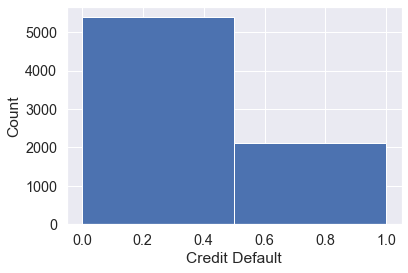

In [104]:
# Гистограмма распределения целевого класса
df_train['Credit Default'].hist(bins=2)
plt.ylabel('Count')
plt.xlabel('Credit Default')

Как видно, значения целевого класса несбалансированы

### Работа с пропусками

In [105]:
# Выводим параметры с пропусками
def missins_values(df):
    cols_miss_feats = [ col for col in df.columns if df[col].count() < df.shape[0] ]
    return cols_miss_feats

In [106]:
print(missins_values(df_train))
print(missins_values(df_test))

['Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Credit Score']
['Annual Income', 'Years in current job', 'Months since last delinquent', 'Bankruptcies', 'Credit Score']


Видим пропуски в аналогичных параметрах тренировочного и тестового набора

In [107]:
# Обзор параметров тренировочного датасета
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [108]:
# Обзор параметров тестового датасета
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

<b>Интересное наблюдение:</b> количество пропусков в признаках Annual Income и Credit Score одинаковое.

<b>Интересное наблюдение:</b> процентное соотношение пропусков в тренировочном и тестовом датасетах приблизительно одинаковое. Возможно, это предусмотрено заданием курсового проекта

In [109]:
# Анализируем, соответствуют ли пропуски Annual Income и Credit Score
df = df_train.loc[(df_train['Annual Income'].isna()) & (df_train['Credit Score'].isna())]
print(df_train.shape[0] - df.shape[0])

5943


Как видно, пропуски в Annual Income и Credit Score соответствуют одним и тем же объектам. Вывод - Credit Score пропущен, так как не указан Annual Income.

##### Матрица корреляции признаков

<AxesSubplot:>

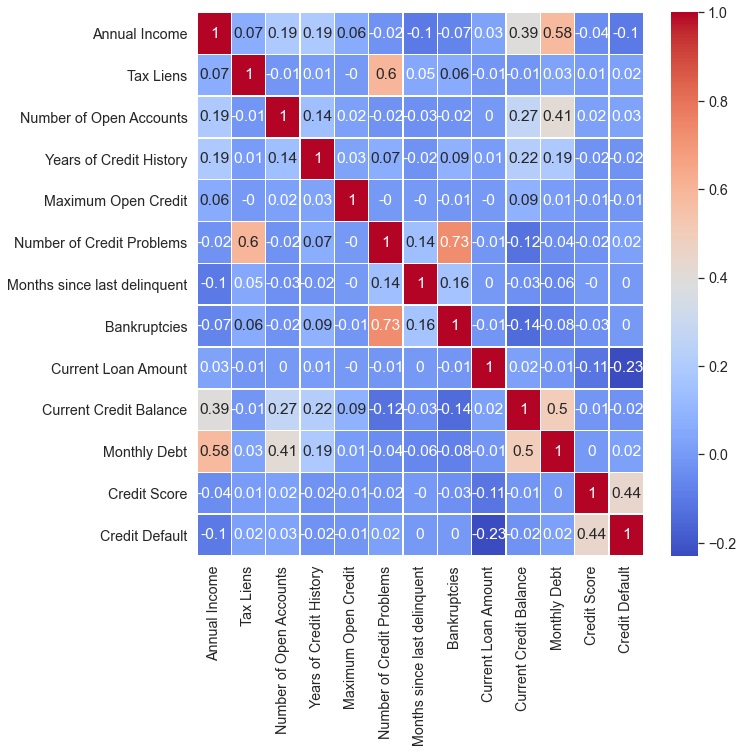

In [110]:
# Строим матрицу корреляций признаков тренировочного датасета
cor_matrix = np.round(df_train.corr(), 2)   # Округление до 2х знаков после запятой

plt.figure(figsize = (10,10))
sns.set(font_scale=1.3)
sns.heatmap(cor_matrix, annot=True, linewidths=.5, cmap='coolwarm')

Наблюдается хорошая корреляция параметров 'Annual Income' vs 'Monthly Debt', а также 'Bankruptcies' vs 'Number of Credit Problems'. Обучим линейную регрессию для заполнения пропущенных значений.

In [111]:
# Функция для предсказания пропущенных значений через коррелирующие параметры. Используется модель линейной регрессии.

def fillna_by_lr(df, feature, target):
    # Отдельный датафрейм для предсказания
    df_lr = pd.DataFrame({
        feature: df[feature],
        target: df[target]
    })
    
    # Удаляем пропуски
    df_lr.dropna(inplace=True)
    
    # Отделяем целевую переменную
    X = df_lr.drop(columns=target)
    y = df_lr[target]
    
    # Обучаем линейную модель
    lr = LinearRegression()
    lr.fit(X, y)
    
    # Предскажем весь столдец целевого признака
    predicted_feature = lr.predict(
        pd.DataFrame({feature: df[feature]}))
    
    # Заполним пропуски предсказаниями
    df[target].fillna(pd.Series(predicted_feature), inplace=True)

In [112]:
fillna_by_lr(df_train, 'Monthly Debt', 'Annual Income')
fillna_by_lr(df_train, 'Number of Credit Problems', 'Bankruptcies')

##### Распределение параметра Credit Score

C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `k

<AxesSubplot:xlabel='Credit Score', ylabel='Density'>

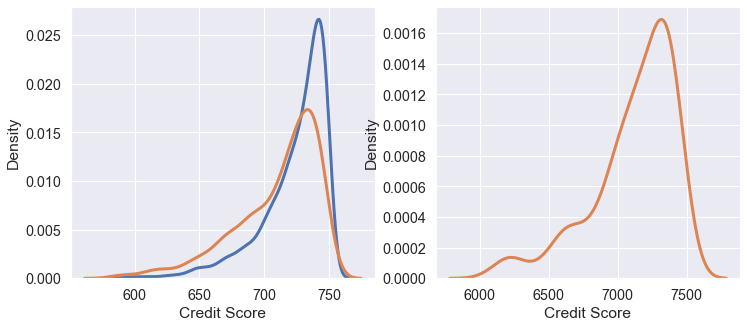

In [113]:
plt.figure(figsize = (12, 5))

target_0 = df_train[df_train['Credit Default'] == 0]
target_1 = df_train[df_train['Credit Default'] == 1]

plt.subplot(121)
sns.distplot(target_0.loc[target_0['Credit Score'] < 1000, 'Credit Score'], hist=False,
            label='no default', kde_kws=dict(linewidth=3))
sns.distplot(target_1.loc[target_1['Credit Score'] < 1000, 'Credit Score'], hist=False, 
            label='default', kde_kws=dict(linewidth=3))

plt.subplot(122)
sns.distplot(target_0.loc[target_0['Credit Score'] > 1000, 'Credit Score'], hist=False, 
            label='no default', kde_kws=dict(linewidth=3))
sns.distplot(target_1.loc[target_1['Credit Score'] > 1000, 'Credit Score'], hist=False, 
            label='default', kde_kws=dict(linewidth=3))

На левом графике представлено распределение параметра 'Credit Score' размером до 1000, на правом более 1000.

In [114]:
# Вычисляем медианы параметра 'Credit Score' для разных значений целевой переменной
credit_score_median_0 = target_0['Credit Score'].median()
credit_score_median_1 = target_1['Credit Score'].median()
print(credit_score_median_0)
print(credit_score_median_1)

732.0
730.5


Медианы между собой отличаются не сильно, поэтому в тестовом датафрейме можно заполнить общей медианой

In [116]:
# Заполняем пропуски в 'Credit Score' соответствующими медианами
condition_0 = (df_train['Credit Score'].isna()) & (df_train['Credit Default'] == 0)
condition_1 = (df_train['Credit Score'].isna()) & (df_train['Credit Default'] == 1)
df_train.loc[condition_0, 'Credit Score'] = credit_score_median_0
df_train.loc[condition_1, 'Credit Score'] = credit_score_median_1

##### 'Years in current job'

Будем считать, что пропуски в данном параметре означают, что клиент не трудоустроен. Соответственно пропуски можно заполнить минимальным значением.

In [117]:
df_train['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [118]:
# Заполняем пропуски
df_train['Years in current job'].fillna('< 1 year', inplace=True)

##### 'Months since last delinquent'

In [119]:
# Заполняем пропуски медианой
df_train['Months since last delinquent'].fillna(df_train['Months since last delinquent'].median(), inplace=True)

### Обработка признаков

##### 'Home Ownership'

In [120]:
df_train['Home Ownership'].unique()

array(['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage'], dtype=object)

Признак 'Home Ownership' является категориальным, поэтому заменим его на дамми-переменные

In [121]:
home_ownership_dummies = pd.get_dummies(df_train['Home Ownership'], prefix='Home Ownership')
df_train = pd.concat([df_train, home_ownership_dummies], axis=1)

##### 'Years in current job'

In [122]:
df_train['Years in current job'].unique()

array(['< 1 year', '10+ years', '8 years', '6 years', '7 years',
       '5 years', '1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

Признак обозначен строковыми данными, хотя несет числовой смысл. Заменим значения его числами

In [123]:
df_train['Years in current job'] = df_train['Years in current job'].map({
        '10+ years': 10,
        '9 years': 9,
        '8 years': 8,
        '7 years': 7,
        '6 years': 6,
        '5 years': 5,
        '4 years': 4,
        '3 years': 3,
        '2 years': 2,
        '1 year': 1,
        '< 1 year': 0
    }).astype(np.int8)

##### 'Purpose'

In [124]:
df_train['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

Признак категориальный,  заменим его на дамми-переменные

In [125]:
purpose_dummies = pd.get_dummies(df_train['Purpose'], prefix='Purpose')
df_train = pd.concat([df_train, purpose_dummies], axis=1)

##### 'Term'

In [126]:
df_train['Term'].unique()

array(['Short Term', 'Long Term'], dtype=object)

Этот признак - бинарный, его значения можно заменить на 0 и 1

In [127]:
df_train['Term'] = df_train['Term'].map({
        'Short Term': 0,
        'Long Term': 1
    }).astype(np.int8)

### Предобработка данных

##### Отбор признаков

Уберем признаки типа 'object', так как в датафрейм добавлены их числовые аналоги

In [128]:
str_features = [ col for col in df_train.columns if df_train[col].dtype == 'O' ]
df_train.drop(columns=str_features, inplace=True)

##### Балансировка данных

In [130]:
TARGET_NAME = 'Credit Default'
df_balanced = balance_df_by_target(df_train, TARGET_NAME)

##### Отделяем целевую переменную

In [131]:
X = df_balanced.drop('Credit Default', axis=1)
y = df_balanced['Credit Default']

##### Разделение на тренировочную и валидационную выборку

In [142]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

### Обучение и оценка модели

##### XGBoost

In [143]:
model_xgb = xgb.XGBClassifier(random_state=42)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_valid_pred = model_xgb.predict(X_valid)

C:\Users\LENOVO\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:38:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Оценка модели

In [144]:
print(f'F1 на тренировочной выборке: {f1_score(y_train, y_train_pred):.2f}')
print(f'F1 на валидационной выборке: {f1_score(y_valid, y_valid_pred):.2f}')

# Матрица ошибок
conf_matrix = confusion_matrix(y_valid, y_valid_pred)

TP = conf_matrix[1][1]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

F1 на тренировочной выборке: 0.99
F1 на валидационной выборке: 0.83
Precision: 0.85
Recall: 0.81


##### LightGBM

In [147]:
model_lgbm = lgbm.LGBMClassifier(random_state=42)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_valid)

Оценка модели

In [148]:
print(f'F1 на тренировочной выборке: {f1_score(y_train, y_train_pred):.2f}')
print(f'F1 на валидационной выборке: {f1_score(y_valid, y_valid_pred):.2f}')

# Матрица ошибок
conf_matrix = confusion_matrix(y_valid, y_valid_pred)

TP = conf_matrix[1][1]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

F1 на тренировочной выборке: 0.95
F1 на валидационной выборке: 0.81
Precision: 0.86
Recall: 0.76


##### CatBoost

In [145]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=42)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

Оценка модели

In [146]:
print(f'F1 на тренировочной выборке: {f1_score(y_train, y_train_pred):.2f}')
print(f'F1 на валидационной выборке: {f1_score(y_valid, y_valid_pred):.2f}')

# Матрица ошибок
conf_matrix = confusion_matrix(y_valid, y_valid_pred)

TP = conf_matrix[1][1]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]

precision = TP / (TP + FP)
recall = TP / (TP + FN)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

F1 на тренировочной выборке: 0.92
F1 на валидационной выборке: 0.78
Precision: 0.86
Recall: 0.72


На основе полученных данных, для тестового датасета будет использована модель XGBoost, так как F1-score выше

### Обработка данных тестового датасета

In [191]:
# Заполнение пропусков линейной регрессией
fillna_by_lr(df_test, 'Monthly Debt', 'Annual Income')
fillna_by_lr(df_test, 'Number of Credit Problems', 'Bankruptcies')

# Заполнение медианой признака 'Credit Score'
credit_score_median = df_test['Credit Score'].median()
df_test['Credit Score'].fillna(credit_score_median, inplace=True)

# 'Years in current job'
df_test['Years in current job'].fillna('< 1 year', inplace=True)
df_test['Years in current job'] = df_test['Years in current job'].map({
        '10+ years': 10,
        '9 years': 9,
        '8 years': 8,
        '7 years': 7,
        '6 years': 6,
        '5 years': 5,
        '4 years': 4,
        '3 years': 3,
        '2 years': 2,
        '1 year': 1,
        '< 1 year': 0
    }).astype(np.int8)

# Заполняем пропуски медианой
df_test['Months since last delinquent'].fillna(df_test['Months since last delinquent'].median(), inplace=True)

# 'Home Ownership'
home_ownership_dummies = pd.get_dummies(df_test['Home Ownership'], prefix='Home Ownership')
df_test = pd.concat([df_test, home_ownership_dummies], axis=1)

# 'Purpose'
purpose_dummies = pd.get_dummies(df_test['Purpose'], prefix='Purpose')

df_test = pd.concat([df_test, purpose_dummies], axis=1)

# 'Term'
df_test['Term'] = df_test['Term'].map({
        'Short Term': 0,
        'Long Term': 1
    }).astype(np.int8)

# Удаление строковых данных
str_features = [ col for col in df_test.columns if df_test[col].dtype == 'O' ]
df_test.drop(columns=str_features, inplace=True)

In [137]:
# Проверяем, заполнение пропусков
print(missins_values(df_test))

[]


In [158]:
print(X_train.shape)
print(df_test.shape)dd

(6729, 33)
(2500, 32)


Видно, что после обработки тестового датасета в нем на 1 признак меньше, чем в тренировочном. Надо его найти и заполнить нулями

In [161]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Years in current job          2500 non-null   int8   
 2   Tax Liens                     2500 non-null   float64
 3   Number of Open Accounts       2500 non-null   float64
 4   Years of Credit History       2500 non-null   float64
 5   Maximum Open Credit           2500 non-null   float64
 6   Number of Credit Problems     2500 non-null   float64
 7   Months since last delinquent  2500 non-null   float64
 8   Bankruptcies                  2500 non-null   float64
 9   Term                          2500 non-null   int8   
 10  Current Loan Amount           2500 non-null   float64
 11  Current Credit Balance        2500 non-null   float64
 12  Monthly Debt                  2500 non-null   float64
 13  Cre

В тестовом датасете отсутствует признак ' Purpose_renewable energy '

In [192]:
# Разделяем
drop_features = ['Purpose_small business', 'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding']
df_test1 = df_test.copy()
df_test1 = df_test1.drop(drop_features, axis=1)
Z = np.zeros(2500)
purpose_renewable_energy = pd.DataFrame({'Purpose_renewable energy': Z}, dtype='uint8')
df_test1 = pd.concat([df_test1, purpose_renewable_energy], axis=1)
df_test = pd.concat([df_test1, df_test[drop_features]], axis=1)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Annual Income                 2500 non-null   float64
 1   Years in current job          2500 non-null   int8   
 2   Tax Liens                     2500 non-null   float64
 3   Number of Open Accounts       2500 non-null   float64
 4   Years of Credit History       2500 non-null   float64
 5   Maximum Open Credit           2500 non-null   float64
 6   Number of Credit Problems     2500 non-null   float64
 7   Months since last delinquent  2500 non-null   float64
 8   Bankruptcies                  2500 non-null   float64
 9   Term                          2500 non-null   int8   
 10  Current Loan Amount           2500 non-null   float64
 11  Current Credit Balance        2500 non-null   float64
 12  Monthly Debt                  2500 non-null   float64
 13  Cre

##### Предсказание на тестовом датафрейме

In [206]:
y_pred = model_xgb.predict(df_test)

In [207]:
# Сохранение предсказаний
submit = pd.read_csv(SUBMIT_DATASET_PATH)
submit['Credit Default'] = y_pred
submit.to_csv('RShafigullin_predictions.csv', index=False)